<a href="https://colab.research.google.com/github/foxtrotmike/rocch/blob/master/roc_VA_std.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Fold 0 Pos: 27 Neg 111
Fold 1 Pos: 89 Neg 51
Fold 2 Pos: 22 Neg 120
Fold 3 Pos: 61 Neg 194
Fold 4 Pos: 91 Neg 5


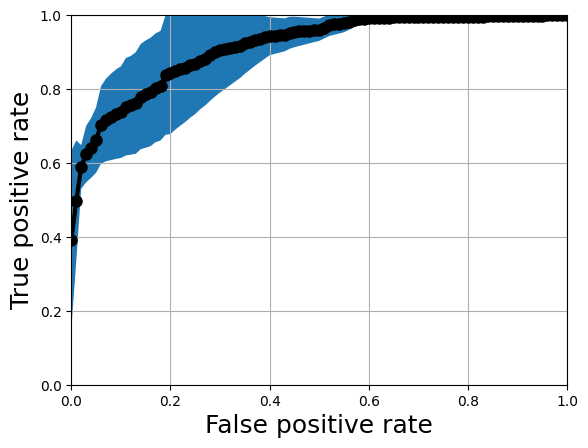

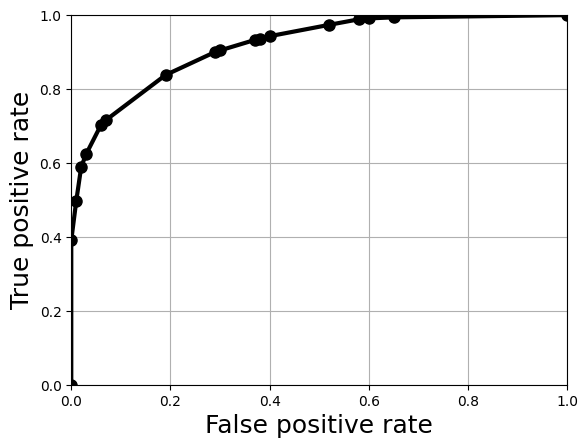

AUC-ROC: 0.9020928794133376 AUC-ROCCH: 0.9168019250293924


In [7]:
"""
Module for computing ROC curves and AUC scores
Modified by Dr. Fayyaz Minhas
Originally from: https://sourceforge.net/projects/pyml/

"""

import numpy
from bisect import bisect_left # for binary search
import numpy.random as rand
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
import numpy as np
__docformat__ = "restructuredtext en"

def roc( labels, dvals, rocN=None, normalize=True ) :
    """
    Compute ROC curve coordinates and area

    - `dvals`  - a list with the decision values of the classifier
    - `labels` - list with class labels with positive class as +1 (all other will be taken as negative)

    returns (FP coordinates, TP coordinates, AUC )
    """
    if rocN is not None and rocN < 1 :
        rocN = int(rocN * numpy.sum(numpy.not_equal(labels, 1)))

    TP = 0.0  # current number of true positives
    FP = 0.0  # current number of false positives

    fpc = [ 0.0 ]  # fp coordinates
    tpc = [ 0.0 ]  # tp coordinates
    dv_prev = -numpy.inf # previous decision value
    TP_prev = 0.0
    FP_prev = 0.0
    area = 0.0

    num_pos = labels.count( 1 )  # number of pos labels
    num_neg = len(labels)-num_pos # number of neg labels

    if num_pos == 0 or num_pos == len(labels) :
        raise(ValueError( "There must be at least one example from each class"))


    # sort decision values from highest to lowest
    indices = numpy.argsort( dvals )[ ::-1 ]

    idx_prev = -1
    for idx in indices:
        # increment associated TP/FP count
        if labels[ idx ] == 1:
            TP += 1.
        else:
            FP += 1.
            if rocN is not None and FP == rocN :
                break
        # Average points with common decision values
        # by not adding a coordinate until all
        # have been processed
        if dvals[ idx ] != dv_prev:
            if len(fpc) > 0 and FP == fpc[-1] :
                tpc[-1] = TP
            else :
                fpc.append( FP  )
                tpc.append( TP  )
            dv_prev = dvals[ idx ]
            area += _trap_area( ( FP_prev, TP_prev ), ( FP, TP ) )
            FP_prev = FP
            TP_prev = TP
            idx_prev = idx

    # Last few decision values were all the same,
    # so must append final points and area
    if idx_prev != indices[-1] :
        tpc.append(num_pos)
        fpc.append(num_neg)
        area += _trap_area( ( FP, TP ), ( FP_prev, TP_prev ) )

    #area += _trap_area( ( FP, TP ), ( FP_prev, TP_prev ) )
    #fpc.append( FP  )
    #tpc.append( TP )

    if normalize :
        fpc = [ float( x ) / FP for x in fpc ]
        if TP > 0:
            tpc = [ float( x ) / TP for x in tpc ]
        if area > 0:
            area /= ( num_pos * FP )

    return fpc, tpc, area

def roc_VA( folds, rocN=None, n_samps=100 ):
    """
    Compute ROC curve using vertical averaging

    `folds` - list of ( labels, dvals ) pairs where labels
              is a list of class labels and dvals are
              the decision values of the classifier
    """
    # return variables
    invl = 1.0 / n_samps # interval to sample FPR
    FPRs = numpy.arange( 0, (1+invl), invl )
    TPRs = [ ] # will contain assoc TPR avgs for FPRs
    # folds must be listified
    assert type( folds ) == type( [ ] )
    rocs = [ ] # list of roc tuples ( [FPR,TPR] ) for folds
    areas = [ ] # individual AUCs for each fold
    TPR_std = []

    # calculate individual ROC curves for each fold
    for dvals,labels in folds:
        fpc, tpc, area = roc( dvals, labels, rocN )
        rocs.append( (fpc, tpc) )
        areas.append( area )

    for fpr in FPRs:
        # accumulate TPRs for current fpr over all folds
        tpr_folds = [ ]
        # fix FPR and accumulate (interpolated) TPRs
        for fpc, tpc in rocs:
            tpr_folds.append( _tpr_for_fpr( fpc, tpc, fpr ))
        # average tprs and append
        TPRs.append( numpy.mean( tpr_folds ) )
        TPR_std.append( numpy.std( tpr_folds ) )

    return FPRs, numpy.array( TPRs ), numpy.array(TPR_std), numpy.mean( areas ), numpy.std(areas)


def _tpr_for_fpr( fpc, tpc, fpr ):
    """
    Returns the (estimated) tpr for the given fpr for
    the given false positive/true positive coordinates
    from an ROC curve.

    `fpc` - False positive coordinates from ROC curve
    `tpc` - True positive coordinates from ROC curve
    """

    # take advantage of monotonic property of ROC curves
    # and search for fpr in O( log n ) time
    idx = bisect_left( fpc, fpr, 0, len(fpc)-1 )

    # if exact match, then return
    if fpc[ idx ] == fpr:
        return tpc[ idx ]

    else:
        # check if idx is last index of fpc
        #if idx == len( fpc ) - 1:
        #    return tpc[ idx ]

        # check if the neighboring fprs are identical
        #elif fpc[ idx ] == fpc[ idx + 1 ]:
            # return the average of the tprs
        #    return ( tpc[ idx ] + tpc[ idx+1 ] ) / 2.0
        # otherwise, interpolate the tpr
        return _interpolate( ( fpc[ idx-1 ], tpc[ idx-1 ] ),
                             ( fpc[ idx ], tpc[ idx ] ),
                             fpr )

def _interpolate( p1, p2, x ):
    """
    Interpolate the value of f( x ).

    `p1` - 1st interpolation point (x1, y1)
    `p1` - 2nd interpolation point (x2, y2)
    `x`  - the value to interpolate
    """
    return p1[ 1 ] + _slope( p1, p2 ) * ( x - p1[ 0 ] )

def _trap_area( p1, p2 ):
    """
    Calculate the area of the trapezoid defined by points
    p1 and p2

    `p1` - left side of the trapezoid
    `p2` - right side of the trapezoid
    """
    base = abs( p2[ 0 ] - p1[ 0 ] )
    avg_ht = ( p1[ 1 ] + p2[ 1 ] ) / 2.0

    return base * avg_ht

def _slope( p1, p2 ):
    """
    Calculates the slope of the line defined by
    points p1 and p2
    """
    delta_x = p2[ 0 ] - p1[ 0 ]
    delta_y = p2[ 1 ] - p1[ 1 ]

    # if infinite slope, scream
    if delta_x == 0: raise( "Infinite slope" )

    return float( delta_y ) / delta_x

def plotROC(rocFP, rocTP, rocTP_std = None, fileName = None, **args) :
    """plot the ROC curve from a given Results (or Results-like) object

    :Parameters:
      - `res` - Results (or Container object that was made by saving a a
        Results object (note that if you have a Results object you can
        use this function as a method so there is no need to supply this
        argument).
      - `fileName` - optional argument - if given, the roc curve is saved
        in the given file name.  The format is determined by the extension.
        Supported extensions: .eps, .png, .svg

    :Keywords:
      - `normalize` - whether to normalize the ROC curve (default: True)
      - `plotStr` - which string to pass to matplotlib's plot function
        default: 'k-'
      - `axis` - redefine the figure axes; takes a list of the form
        [xmin,xmax,ymin,ymax]
      - `show` - whether to show the ROC curve (default: True)
        useful when you just want to save the curve to a file.
        The use of Some file formats automatically sets this to False
        (e.g. svg files).  This relates to quirks of matplotlib.
    """

    if 'show' in args :
        show = args['show']
    else :
        show = True
    if 'plotStr' in args :
        plotStr = args['plotStr']
    else :
        plotStr = 'ko-'
    rocNormalize = True
    if 'normalize' in args :
        rocNormalize = args['normalize']

    numPoints = 200
    if 'numPoints' in args :
        numPoints = args['numPoints']

    stride = int(max(1, float(len(rocTP)) / float(numPoints)))

    if stride > 1 :
        rocTP = [rocTP[i] for i in range(0,len(rocTP), stride)]
        rocFP = [rocFP[i] for i in range(0,len(rocFP), stride)]

    import matplotlib
    if fileName is not None and fileName.find('.svg') > 0 :
        matplotlib.use('SVG')
        show = False
    if fileName is not None and fileName.find('.eps') > 0 :
        matplotlib.use('PS')
        show = False

    from matplotlib import pylab
    lines = pylab.plot(rocFP, rocTP, plotStr,
                       markersize = 8, linewidth = 3)
    if rocTP_std is not None:
      pylab.fill_between(rocFP, rocTP-rocTP_std, rocTP+rocTP_std)

    if rocNormalize :
        pylab.xlabel('False positive rate', fontsize = 18)
        pylab.ylabel('True positive rate', fontsize = 18)
    else :
        pylab.xlabel('False positives', fontsize = 18)
        pylab.ylabel('True positives', fontsize = 18)
    if rocNormalize :
        pylab.axis([0, 1, 0, 1])
    if 'axis' in args :
        pylab.axis(args['axis'])
    if fileName is not None :
        pylab.savefig(fileName)
    if show :
        plt.grid()
        pylab.show()


def rocch(fpr0,tpr0):
    """
    @author: Dr. Fayyaz Minhas (http://faculty.pieas.edu.pk/fayyaz/)
    Construct the convex hull of a Receiver Operating Characteristic (ROC) curve
        Input:
            fpr0: List of false positive rates in range [0,1]
            tpr0: List of true positive rates in range [0,1]
                fpr0,tpr0 can be obtained from sklearn.metrics.roc_curve or
                    any other packages such as pyml
        Return:
            F: list of false positive rates on the convex hull
            T: list of true positive rates on the convex hull
                plt.plot(F,T) will plot the convex hull
            auc: Area under the ROC Convex hull
    """
    fpr = np.array([0]+list(fpr0)+[1.0,1,0])
    tpr = np.array([0]+list(tpr0)+[1.0,0,0])
    hull = ConvexHull(np.vstack((fpr,tpr)).T)
    vert = hull.vertices
    vert = vert[np.argsort(fpr[vert])]
    F = [0]
    T = [0]
    for v in vert:
        ft = (fpr[v],tpr[v])
        if ft==(0,0) or ft==(1,1) or ft==(1,0):
            continue
        F+=[fpr[v]]
        T+=[tpr[v]]
    F+=[1]
    T+=[1]
    auc = np.trapz(T,F)
    return F,T,auc

if __name__=='__main__':
    # Testing
    ############## Make synthetic data #################
    # Simulate protein binding site by having few positive
    # class examples
    folds = [ ]
    N = 5  # number of folds
    # set means of decision values
    mu_n = -1
    mu_p = 1
    # draw decision values from normal distribution for each class
    for i in range( N ):
        Np = int(100*np.random.rand())+1
        Nn = int(200*np.random.rand())+1
        preds = rand.normal( mu_n, 1, Nn ).tolist()
        preds.extend( rand.normal( mu_p, 1, Np ).tolist() )
        labs = [ -1 ] * Nn
        labs.extend( [ 1 ] * Np )
        print("Fold",i,"Pos:",Np,"Neg",Nn)
        folds.append( ( labs[ : ], preds ) )
    ############## Plot Convex Hull ROC #################
    # Calculate average ROC curve
    fpr0, tpr0, tpr_std, area0, area_std = roc_VA( folds ) #get average plot across folds
    plotROC(fpr0, tpr0, tpr_std);
    fpr,tpr,area = rocch(fpr0,tpr0) #make convex hull
    plotROC(fpr, tpr);
    print("AUC-ROC:",area0,"AUC-ROCCH:",area)
    # You can plot your own way by using the line below
    #plt.plot(fpr,tpr); plt.grid(); plt.xlabel('FPR'); plt.ylabel('TPR')



In [5]:
import numpy as np
z = np.random.rand(100)
y = np.random.randint(0,2,100)
roc

<function __main__.roc(labels, dvals, rocN=None, normalize=True)>

In [6]:
y

array([0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0,
       1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0])